In [450]:
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import scipy
from scipy.stats import binom, chi2, poisson, ttest_ind, fisher_exact, hypergeom, norm
import seaborn as sns
import matplotlib.pyplot as plt

## Networkx Tutorial

In [2]:
# create nework object
## Way1, by manual
### nx.Graph() # if undirected 
### nx.DiGraph() # if directed
### nx.MultiGraph # if MultiGraph
### nx.DiMultiGraph # if directed MultiGraph
ex1 = nx.DiGraph() # if directed

### adding nodes and edges from ANY iterable container, such as list
#### adding unweighted edges
V={1,2,3,4,5}
E={(1,2),(2,3),(3,4),(4,5),(5,2)}
ex1.add_nodes_from(V)
ex1.add_edges_from(E)
#### adding weighted edges
e = [('a', 'b', 0.3), ('b', 'c', 0.9), ('a', 'c', 0.5), ('c', 'd', 1.2)]
ex1.add_weighted_edges_from(e)


## Way2, create graph from edge list stored in data file
E_path =  './release_directed_graph.txt'
ex2 = nx.read_edgelist(E_path,
                     create_using = nx.DiGraph(), # Use Graph() instead of DiGraph() for directed vs. undirected, 
                     nodetype = int) # Do not forget to specify node information type
## Way3, create graph from numpy adjacency matrix
A = [[0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 1, 0, 0, 0, 0, 0], 
    [0, 1, 0, 1, 1, 0, 0, 0], 
    [1, 0, 1, 0, 0, 0, 0, 0], 
    [0, 0, 1, 0, 0, 1, 0, 0], 
    [0, 0, 0, 0, 1, 0, 1, 0], 
    [0, 0, 0, 0, 0, 1, 0, 1], 
    [0, 0, 0, 0, 0, 0, 1, 0]]
ex3 = nx.from_numpy_matrix(np.array(A), create_using=nx.Graph)

examples=[ex1, ex2, ex3]

In [3]:
# basic properties
## nodes and edges
print(f'Listing nodes\n {list(ex1.nodes)}')
print(f'Listing edges\n {list(ex1.edges)}')

Listing nodes
 [1, 2, 3, 4, 5, 'a', 'b', 'c', 'd']
Listing edges
 [(1, 2), (2, 3), (3, 4), (4, 5), (5, 2), ('a', 'b'), ('a', 'c'), ('b', 'c'), ('c', 'd')]


In [13]:
# from network to adjacency matrix
## sparse matrix
adj_ex1 = nx.adjacency_matrix(ex1)
## dence matrix
adj_ex3 = nx.to_numpy_array(ex3)

# print(adj_ex1.todense())
# print(adj_ex3)

## Types of Graphs

In [318]:
class graph_properties():
    def __init__(self, nodes=None, edges=None, adjmat=None):
        self.nodes = nodes
        self.edges = edges
        self.selfloop = False
        self.directed = True
        # Adjacency_Matrix
        if type(adjmat) == type(None):
            self.adjmat = np.zeros((len(nodes),len(nodes)))
            for edge in edges:
                if type(edge)== set:
                    self.directed = False
                    edge = list(edge)
                    if len(edge) == 1:
                        self.selfloop = True
                        self.adjmat[edge[0]-1,edge[0]-1]+=1
                    else:
                        self.adjmat[edge[0]-1,edge[1]-1]+=1
                        self.adjmat[edge[1]-1,edge[0]-1]+=1
                else:
                    self.adjmat[edge[0]-1,edge[1]-1]+=1
        else:
            self.adjmat = adjmat
        self.symmetric = (self.adjmat==self.adjmat.T).all()
        self.acyclic = np.allclose(np.linalg.eig(self.adjmat)[0],0)
        
    def properties(self):
        # Undirected or Directed
        ## type(edges) == set, Undirected
        if self.directed:
            if self.symmetric:
                print('Directed network and symmetric Adjacency_Matrix')
            else:
                print('Directed network')
        else:
            print('Undirected network')
        # acyclic or cyclic
        ## if adjmat's eigenvalues all = 0, acyclic
        if self.acyclic:
            print('Acyclic network')
        else:
            print('Cyclic network')
        # simple or Multi
        ## if no self-loop or at-most 1 edge in any pair of nodes, simple
        if not self.selfloop and (np.max(self.adjmat)<=1) and self.symmetric:
            print('Simple graph')
        else:
            print('Multigraph')
            
def bipartite_sets(network):
    set1 = set()
    set2 = set()
    elements_notin_set = np.vectorize(lambda x, set_ : x not in set_)
    
    adja_matrix = nx.to_numpy_array(network)
    if np.trace(adja_matrix) != 0:
        return('Find self-loop, can not be bipartite')
    non_classified_nodes = list(network.nodes)
    classified_nodes = []
    start_from = min(non_classified_nodes)
    c=0
    while non_classified_nodes:
        for node in non_classified_nodes:
            py_index = node-start_from
            neighbors = np.hstack([np.where(adja_matrix[py_index]>0)[0], np.where(adja_matrix[:,py_index]>0)[0]])+1
            
            node_not_in_set1 = node not in set1
            node_not_in_set2 = node not in set2
            try:
                neighnor_not_in_set1 = elements_notin_set(neighbors, set1)
                neighnor_not_in_set2 = elements_notin_set(neighbors, set2)
            except:
                neighnor_not_in_set1 = np.array([])
                neighnor_not_in_set2 = np.array([])
            if not classified_nodes: # if classified_nodes is empty
                set1.update({node})
                set2.update(set(neighbors))
                non_classified_nodes.remove(node)
                classified_nodes.append(node)
            elif node in set1 or node in set2:
                if node_not_in_set1 and neighnor_not_in_set2.all():
                    set2.update({node})
                    try:
                        set1.update(set(neighbors))
                    except ValueError:
                        pass
                    non_classified_nodes.remove(node)
                    classified_nodes.append(node)
                elif node_not_in_set2 and neighnor_not_in_set1.all():
                    set1.update({node})
                    try:
                        set2.update(set(neighbors))
                    except ValueError:
                        pass
                    non_classified_nodes.remove(node)
                    classified_nodes.append(node)
        c+=1
        if c > len(list(network.nodes)):
            return  non_classified_nodes, print('Probably not bipartite')
    return set1, set2

In [319]:
#1
V={1,2,3,4,5}
E={(1,2),(2,3),(3,4),(4,5),(5,2)}
G = nx.DiGraph() 
G.add_nodes_from(V)
G.add_edges_from(E)
adja_matrix = nx.to_numpy_array(G)

# check properties
## if a nework is potential undirected, adja_matrix == adja_matrix.T
print('Potential undirected network? \n', (adja_matrix == adja_matrix.T).all())
## if a network is Acyclic, all eigenvalues of adja_matrix == 0
eig_values = np.linalg.eig(adja_matrix)[0]
print('All eig_values close to 0?\n', np.allclose(eig_values,0))

Potential undirected network? 
 False
All eig_values close to 0?
 False


In [320]:
#2
V={1,2,3,4,5}
E={(1,2),(1,4),(3,4),(4,5),(5,2)}
G = nx.DiGraph() 
G.add_nodes_from(V)
G.add_edges_from(E)
adja_matrix = nx.to_numpy_array(G)

# check properties
## if a nework is potential undirected, adja_matrix == adja_matrix.T
print('Potential undirected network? \n', (adja_matrix == adja_matrix.T).all())
## if a network is Acyclic, all eigenvalues of adja_matrix == 0
eig_values = np.linalg.eig(adja_matrix)[0]
print('All eig_values close to 0?\n', np.allclose(eig_values,0))

Potential undirected network? 
 False
All eig_values close to 0?
 True


In [321]:
#3
V={1,2,3,4,5}
E=[{1,2},{1,4},{3,4},{4,5},{5,2}] #in the notation of an undirected edge, use set {}
G = nx.Graph() #in the notation of an undirected edge, use set {}
G.add_nodes_from(V)
G.add_edges_from(E)
adja_matrix = nx.to_numpy_array(G)

# check properties
## if a nework is potential undirected, adja_matrix == adja_matrix.T
print('Potential undirected network? \n', (adja_matrix == adja_matrix.T).all())
## if a network is Acyclic, all eigenvalues of adja_matrix == 0
eig_values = np.linalg.eig(adja_matrix)[0]
print('All eig_values close to 0?\n', np.allclose(eig_values,0))

Potential undirected network? 
 True
All eig_values close to 0?
 False


In [322]:
#4
V={1,2,3,4,5}
E=[{1,2},{1,4},{3,4},{4,5},{5,2},(3,3)] #in the notation of an undirected edge, use set {}
G = nx.Graph() #in the notation of an undirected edge, use set {}
G.add_nodes_from(V)
G.add_edges_from(E)
adja_matrix = nx.to_numpy_array(G)

# check properties
## if a nework is a simple network, there is no self-loop and at most 1 edge between any two nodes
max_num_edges = np.max(adja_matrix)
num_of_selfloop = np.trace(adja_matrix)
print(f'Maximun number of edges between two nodes=\n {max_num_edges}')
print(f'Number of self-loop=\n {num_of_selfloop}')
bipartite_sets(G)

Maximun number of edges between two nodes=
 1.0
Number of self-loop=
 1.0


'Find self-loop, can not be bipartite'

In [323]:
#5
V={1,2,3,4,5}
E=[{1,2},{1,4},{3,1},{4,5},{5,2}]
G = nx.Graph() #in the notation of an undirected edge, use set {}
G.add_nodes_from(V)
G.add_edges_from(E)
adja_matrix = nx.to_numpy_array(G)

# check properties
## if a nework is a simple network, there is no self-loop and at most 1 edge between any two nodes
max_num_edges = np.max(adja_matrix)
num_of_selfloop = np.trace(adja_matrix)
print(f'Maximun number of edges between two nodes=\n {max_num_edges}')
print(f'Number of self-loop=\n {num_of_selfloop}')
## if a nework is a Bipartite network, 
bipartite_sets(G)

Maximun number of edges between two nodes=
 1.0
Number of self-loop=
 0.0


({1, 5}, {2, 3, 4})

## Adjacency Matrix
Adjacency Matrix = $A$
- A non-zero $A_{i,i}$ represents a loop from node $i$ to itself.
- $A=A^T$ can be directed or undirected.

### Powers of the Adjacency Matrix
- Theorem:
    - Let $A$ be the adjacency matrix of an unweighted graph (could be directed/undirected, simple/multigraph). 
    - $A^l$ is $A$ to the power of $l$, $A$ 的 $l$ 次方
        - $A^l_{i,j}$
            - is the element in row $i$ and column $j$ of $A^l$
            - is the number of walks of length $l$ from node $i$ to node $j$.



In [386]:
# Walks of Length 2 and 3
A = np.array([[1,1,0],[0,0,1],[1,0,0]])
print('Q: How many walks of length 2 are there from node 1 to 2')
A2 = A@A
print(A2[0,1])
print('---')

print('Q: How many walks of length 3 are there from node 1 to 2')
A3 = A2@A
print(A3[0,1])

Q: How many walks of length 2 are there from node 1 to 2
1
---
Q: How many walks of length 3 are there from node 1 to 2
1


## Graph Properties and Metrics

### Connected Components
- Undirected graph
    - A subset of nodes $V' \subset V$ such that:
        - There exists at least one walk from $v_i$ to $v_j$ whenever $v_i\,v_j \in V'$
        - There is no walk from $v_i$ to $v_j$ whenever $v_i \in V' ; v_j \in (V \backslash V')$
            - $V \backslash V'$, 在 $V$ 不在 $V'$
- Directed graph
    - A subset of nodes $V' \subset V$ is ***strongly connected*** such that:
        - every vertex in $V'$ is reachable from every other vertex in $V'$
        - there exists some vertex in $V'$ and some vertex in $(V \backslash V')$ such that there is no directed path between such vertices in at least one direction.

In [354]:
Adjacency_Matrix=np.array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
                            [1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                            [1, 1, 0, 0, 0, 1, 0, 1, 1, 0],
                            [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
                            [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
                            [0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])

In [360]:
G = nx.from_numpy_matrix(np.array(Adjacency_Matrix), create_using=nx.Graph)


In [361]:
print('Q: Does the adjacency matrix represent a simple graph?')

# check number of self-loop
print('Number of self-loops = \n', np.trace(Adjacency_Matrix))
# check at most one edge between pair of nodes
print('The maximun number of edges between pair of nodes= \n', np.max(Adjacency_Matrix))
# check symmetric
print('Adjacency matrix is symmetric?\n', (Adjacency_Matrix==Adjacency_Matrix.T).all())

print('--> this graph is a simple graph')

Q: Does the adjacency matrix represent a simple graph?
Number of self-loops = 
 0
The maximun number of edges between pair of nodes= 
 1
Adjacency matrix is symmetric?
 True
--> this graph is a simple graph


In [362]:
print('Q: Can the adjacency matrix potentially represent an undirected graph?')

print('Adjacency matrix is symmetric?\n', (Adjacency_Matrix==Adjacency_Matrix.T).all())

print('--> yes')

Q: Can the adjacency matrix potentially represent an undirected graph?
Adjacency matrix is symmetric?
 True
--> yes


[neworkx Connected Components](https://networkx.org/documentation/stable/reference/algorithms/component.html?highlight=connect)

In [363]:
print('Q: Is the graph connected?')
print('Q: What is the minimum length of walk "l" such that A^l contains no entry equal to 0?')
print('Q: How many connected components does the graph have?')

number_of_nodes = len(Adjacency_Matrix)
n_length = np.identity(number_of_nodes)
for i in range(number_of_nodes):
    n_length = n_length@Adjacency_Matrix
    if np.min(n_length) > 0:
        print(f'--> Connected, the shorted length = {i+1}')
        break
print(f'--> networkx connected check = {nx.is_connected(G)}')
print(f'--> number of connected components= {nx.number_connected_components(G)}')

Q: Is the graph connected?
Q: What is the minimum length of walk "l" such that A^l contains no entry equal to 0?
Q: How many connected components does the graph have?
--> Connected, the shorted length = 4
--> networkx connected check = True
--> number of connected components= 1


In [371]:
print('Q: What is the maximum degree of a node in the graph?')
print('For an undirected graph, that is not weighted or a multigraph, the diagonal entries of 𝐴2 are equal to the degree of the nodes.')
print('Adjacency_Matrix check=', np.max(np.diagonal(Adjacency_Matrix@Adjacency_Matrix)))
print('networkx check=', np.max(np.array(G.degree())[:,1]))



Q: What is the maximum degree of a node in the graph?
For an undirected graph, that is not weighted or a multigraph, the diagonal entries of 𝐴2 are equal to the degree of the nodes.
Adjacency_Matrix check= 5
networkx check= 5


In [370]:
print('Q: How many walks of length 5 are there from node 0 (represented by first row/column) to itself?')
(Adjacency_Matrix@Adjacency_Matrix@Adjacency_Matrix@Adjacency_Matrix@Adjacency_Matrix)[0,0]

Q: How many walks of length 5 are there from node 0 (represented by first row/column) to itself?


46

### Degree Sum
Let 𝑘1,…,𝑘𝑛 be the degrees of an 𝑛-node undirected, simple graph. Let 𝑒 be the number of edges in the graph.
- Degree Sum
    - $\sum_{i=1}^{N} k_i = 2*|number\ of\ edges|$

In [377]:
# UNdirected
2*(np.sum(Adjacency_Matrix))/2,\
2*len(G.edges), \
np.sum(np.array(G.degree())[:,1]), 

(26.0, 26, 26)

## 7. Graph Properties and Metrics - II

In [389]:
edges = np.loadtxt('release_directed_graph.txt')
edges.shape

(1030, 2)

In [390]:
print('Q: How many nodes does the graph have?')
len(np.unique(edges))

Q: How many nodes does the graph have?


100

In [391]:
print('Q: How many edges does the graph possess?')
edges.shape[0]

Q: How many edges does the graph possess?


1030

In [392]:
print('Q:  Does the graph contain self loops?')
np.sum(edges[:,0] == edges[:,1])

Q:  Does the graph contain self loops?


8

In [393]:
adj_mat = np.zeros((100,100))
for edge in edges:
    i = int(edge[0])
    j = int(edge[1])
    adj_mat[i,j] += 1

In [394]:
no_self_loop = adj_mat.copy()
np.fill_diagonal(no_self_loop, 0)
print(np.trace(no_self_loop))

0.0


In [395]:
p = np.identity((100))
for i in range(100):
    p = p@no_self_loop
    if np.trace(p) >0:
        print(f'found cycle in lengh of wlak = {i+1}')
        break

found cycle in lengh of wlak = 2


### 5. 
This graph was generated using the following model:
- We fixed the number of nodes and every possible directed edge was selected with a probability 𝑝 independently of all other edges. What is the maximum likelihood estimate of 𝑝? Provide an answer accurate to at least five significant figures (graded to 0.01% tolerance), you can also enter your answer as an exact fraction.


In [448]:
maximum_possible_number_of_edges = 100*100 # include self-loop
number_of_edges = np.sum(adj_mat)
Sample_mean = number_of_edges/maximum_possible_number_of_edges
print('Sample mean =  maximum likelihood estimater = ', Sample_mean)

Sample mean =  maximum likelihood estimater =  0.103


### 6.
Given the above generative model
- what is the 𝑝-value of observing this graph for the null hypothesis that 𝑝=0.1? 
    - Assume that the test statistic is $\frac{S_n-\mu_n}{\sigma_n}$, where 𝑆𝑛 is the sample mean and 𝜇𝑛 and 𝜎𝑛 are the mean and standard deviation of the sample mean under the null hypothesis. The sample mean is the fraction of number of edges observed to the total number of possible edges. Use the central limit theorem approximation to compute the required probability. Provide an answer accurate to at least three significant figures (graded to 1% tolerance).
    - The central limit theorem (CLT) states that: When sampling random variables 𝑋1,…,𝑋𝑛 from a population with mean 𝜇 and variance 𝜎2, 𝑋¯ is approximately normally distributed with mean 𝜇 and variance 𝜎2/𝑛 when 𝑛 is large:

$\bar{X}:=X_1+X_2+\dots+X_n \sim \mathcal{N}(\mu,\frac{\sigma^2}{n}) \text{       for n is large}$

In [483]:
# take is problem as 10000 times Bernoulli distribution of p=0.1
n = 100*100
p=0.1

Bernoulli_mean = 0.1
Bernoulli_variance = 0.1*(1-0.1)
null = binom(1, 0.1)

# CLT_population_mean = 0.1
# CLT_population_variance = Bernoulli_variance/n
# CLT_population_standard_deviation = np.sqrt(CLT_population_variance)
# CLT_null = norm(loc = CLT_population_mean, scale = CLT_population_standard_deviation)
CLT_null = norm(loc=0, scale=1)
test_stat = np.abs((Sample_mean - CLT_population_mean)/ CLT_population_standard_deviation)
test_stat

0.9999999999999962

In [511]:
p_value_upper = CLT_null.cdf(test_stat)
p_value_lower = CLT_null.cdf(-test_stat)
p_value = (1-p_value_upper) + p_value_lower
print(p_value)

0.3173105078629159


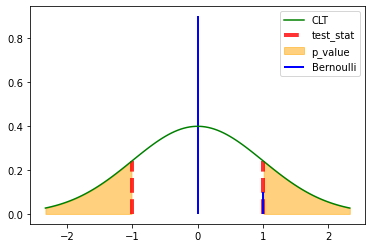

In [510]:
x_ber = np.linspace(null.ppf(0.01),
                      null.ppf(0.99))
x_CLT = np.linspace(CLT_null.ppf(0.01),
                    CLT_null.ppf(0.99), 100)
plt.vlines(test_stat, 0, CLT_null.pdf(test_stat), linestyles='--', colors='red', alpha=0.8, lw=4, label='test_stat')
plt.vlines(-test_stat, 0, CLT_null.pdf(-test_stat), linestyles='--', colors='red', alpha=0.8, lw=4)
plt.fill_between(x=x_CLT[x_CLT<=-test_stat], y1=0, y2=CLT_null.pdf(x_CLT[x_CLT<-test_stat]), color='orange', alpha=0.5, label='p_value')
plt.fill_between(x=x_CLT[x_CLT>=test_stat], y1=0, y2=CLT_null.pdf(x_CLT[x_CLT>test_stat]), color='orange', alpha=0.5)
plt.vlines(x_ber, 0, null.pmf(x_ber), lw=2, label='Bernoulli', color='Blue')
sns.lineplot(x=x_CLT, y=CLT_null.pdf(x_CLT), label='CLT', color='Green')
plt.show()

### Edge Density
The edge density 𝜌 of a graph with 𝑛 nodes and 𝑚 edges is defined as
- $\rho = \frac{m}{C{n\atop 2}}$

This is a metric that captures the fraction of (all possible) edges present in an undirected graph.

#### Circle Graph
Consider the following undirected simple graph on 𝑛 nodes 0,1,…,𝑛−1: Let 𝑘 be some integer in the range 0<𝑘<𝑛 that parametrizes this graph. Then, for every 𝑖∈[0,𝑛−1] we have that node 𝑖 is connected to node (𝑖+𝑘)%𝑛. Here % is the modulo operator.

In [541]:
print('Q: 1. True or False: The simple graph is connected if 𝑛 is a prime number.')
print('Q: 2. Let 𝑛≥3 and let 𝑛 be prime. What is the degree of every node?')
print('Q: 3. Let 𝑛≥3 and let 𝑛 be prime. How many edges does the simple graph have?')
for n in [3,5]:
    n_range = range(n)
    k_range = range(1,n)
    print(f'n = {n}')
    for k in k_range:
        adj_mat = np.zeros((n,n))
        for i in n_range:
            adj_mat[i, (i+k)%n]=1
        G = nx.from_numpy_matrix(np.array(adj_mat), create_using=nx.Graph)
        print(f'k = {k}')
        print('Is G connected?', nx.is_connected(G))
        print('Degree of evey node', G.degree)
        print('number of edges', len(G.edges))
    print('---')

Q: 1. True or False: The simple graph is connected if 𝑛 is a prime number.
Q: 2. Let 𝑛≥3 and let 𝑛 be prime. What is the degree of every node?
Q: 3. Let 𝑛≥3 and let 𝑛 be prime. How many edges does the simple graph have?
n = 3
k = 1
Is G connected? True
Degree of evey node [(0, 2), (1, 2), (2, 2)]
number of edges 3
k = 2
Is G connected? True
Degree of evey node [(0, 2), (1, 2), (2, 2)]
number of edges 3
---
n = 5
k = 1
Is G connected? True
Degree of evey node [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
number of edges 5
k = 2
Is G connected? True
Degree of evey node [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
number of edges 5
k = 3
Is G connected? True
Degree of evey node [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
number of edges 5
k = 4
Is G connected? True
Degree of evey node [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
number of edges 5
---


In [542]:
print('Q: 4. Let 𝑛≥3 and let 𝑛 be prime. What is the edge density 𝜌 of the simple graph?')
print('m=n, C(n,2)=n*(n-1)/2, 𝜌 = 2/(n-1)')

Q: 4. Let 𝑛≥3 and let 𝑛 be prime. What is the edge density 𝜌 of the simple graph?
m=n, C(n,2)=n*(n-1)/2, 𝜌 = 2/(n-1)


### Length of a Path, Diameter, and Average Distance

Let $d_{i,j}$ be the length of the shortest path (or the path with the smallest weight in the case of a weighted graph) between node 𝑖 and 𝑗. The diameter of a graph is the largest distance between any two nodes:
- diameter = $\max\limits_{i,j \in V} d_{i,j}$

We can also define the notion of average shortest path length :
- average path length = $\frac{1}{C{n\atop 2}} \sum_{i\leq j} d_{i,j}$
These notions are defined component-wise in case the graph is not connected. The definition of what constitutes a component, as we have seen before, varies between an undirected graph and a directed graph.

In [ ]:
adj_mat

## Graph Metrics – A Measure of Clustering and Modularity
- Clustering coefficient 
    - $\frac{0.5*trace(Adjacency^3)}{\sum\limits_{i}C{k_i \atop 2}} = \frac{trace(Adjacency^3)}{\sum\limits_{i}k_i(k_i -1)}$
    - $0.5*trace(Adjacency^3)$-> the number of wlaks in length 3 and back to the original nodes
    - $C{k_i \atop 2}$ -> the number of ***three connected nodes*** node{i} can construct when node{i} is the middlemen of ***three connected nodes***
- Modularity, one way to quantify **Homophily**
    - Modularity score = $\frac{1}{2m} \sum\limits_{i,j}\Big( (A_{i,j} - \frac{k_i k_j}{2m}) * \delta (t_i, t_j) \Big)$
    - $\delta (t_i, t_j)= \begin{cases} 1 & \text{if type_i = type_j} \\ 0 & \text{else} \end{cases}$
        - Modularity only consider nodes in the same type
    - $\frac{k_i k_j}{2m}$ -> the ***expeted*** number of edges between node{i} and node{j} if the edges was placed by ramdom
        - Different Homophily measurement has different way to estimate the ***expeted***

In [596]:
adj_mat = np.array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
                    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 0, 0, 0, 1, 0, 1, 1, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
                    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])

In [597]:
# clustering coefficient
connected_tri_func = np.vectorize(lambda x: x*(x-1))
degrees_of_nodes = np.sum(adj_mat, axis=0)
C_coef = np.trace(adj_mat@adj_mat@adj_mat) / np.sum(connected_tri_func(degrees_of_nodes))
C_coef

0.3103448275862069

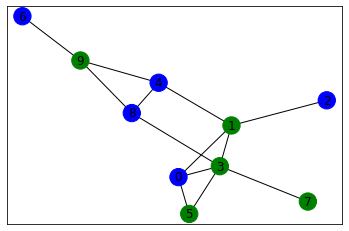

In [624]:
# Modularity
## 1. find nodes in the same class
t1 = [0,2,4,6,8]
t2 = [1,3,5,7,9]
G = nx.from_numpy_array(adj_mat, create_using=nx.Graph)
# nx.maximal_independent_set(G, [0])
# nx.bipartite.sets(G)
node_color = np.empty(adj_mat.shape[0], dtype='object')
node_color[t1] = 'blue'
node_color[t2] = 'green'
nx.draw_networkx(G, node_color=node_color)

In [639]:
type_of_nodes = dict()
type_of_nodes.update({n:1 for n in t1})
type_of_nodes.update({n:2 for n in t2})

degree_of_nodes = np.diagonal(adj_mat@adj_mat)

number_of_edges = np.sum(adj_mat)/2


type_of_nodes[0], type_of_nodes[1], degree_of_nodes

(1, 2, array([3, 4, 1, 5, 3, 2, 1, 1, 3, 3]))

In [640]:
modularity = 0
for i in range(adj_mat.shape[0]):
    for j in range(adj_mat.shape[0]):
        if type_of_nodes[i] == type_of_nodes[j]:
            modularity += (1/(2*number_of_edges)) * (adj_mat[i,j]-(degree_of_nodes[i]*degree_of_nodes[j]/(2*number_of_edges)))

In [641]:
modularity

-0.2041420118343195

In [642]:
def modularity_partition(A, part):
	m = A.sum()/2
	ks = A.sum(axis=0)
	return ( A[part].T[part].T - ks[part][:,None]*ks[part][None,:]/(2*m) ).sum()/(2*m)

def modularity(A, parts):
	return sum([ modularity_partition(A, p) for p in parts ])

modularity(adj_mat, [[0,2,4,6,8], [1,3,5,7,9]])

-0.20414201183431957